In [1]:
import numpy as np
import pandas as pd
import os
import random
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
### READ DATA ###

df = pd.read_csv('AirQualityUCI.csv', sep=';', parse_dates={'date':['Date', 'Time']})
df.dropna(axis=1, inplace=True, how='all')
df.dropna(inplace=True)

df['date'] = pd.to_datetime(df.date , format = '%d/%m/%Y %H.%M.%S')
date = df['date'].values
df.set_index('date', inplace=True)

df.columns = [col.split('(')[0] for col in df.columns]

print(df.shape)
df.head()

(9357, 13)


,CO,PT08.S1,NMHC,C6H6,PT08.S2,NOx,PT08.S3,NO2,PT08.S4,PT08.S5,T,RH,AH
date,,,,,,,,,,,,,
2004-03-10 18:00:00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
2004-03-10 19:00:00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2004-03-10 20:00:00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
2004-03-10 21:00:00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
2004-03-10 22:00:00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [3]:
### ADJUST AND CLEAN DATA ###

df_external = pd.DataFrame(df.index)

for col in df.columns:
    
    if df[col].dtype == object: # correct type
        df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
    
    df[col] = df[col].replace(-200, np.nan) # check nans
    print(col, ':', df[col].isna().sum()/len(df))
    if df[col][:int(len(df)*0.8)].isna().sum()/int(len(df)*0.8) > 0.5: # at least 50% in train not nan
        df.drop(col, axis=1, inplace=True)
    else:
        df[col] = df[col].interpolate(method='linear', limit_direction='both') # fill nans
        
    if col in ['T','RH','AH']:
        df_external[col] = df[col].values
        df.drop(col, axis=1, inplace=True)

CO : 0.17986534145559474
PT08.S1 : 0.0391151009939083
NMHC : 0.9023191193758683
C6H6 : 0.0391151009939083
PT08.S2 : 0.0391151009939083
NOx : 0.17516297958747462
PT08.S3 : 0.0391151009939083
NO2 : 0.1754835951693919
PT08.S4 : 0.0391151009939083
PT08.S5 : 0.0391151009939083
T : 0.0391151009939083
RH : 0.0391151009939083
AH : 0.0391151009939083


In [4]:
### UTILITY FUNCTION FOR CYCLICAL ENCODE VARIABLES ###

def cycle_encode(data, cols):
    
    for col in cols:
        
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        
    return data

In [5]:
### BUILD DATAFRAME OF EXTERNAL VARIABLES ###

df_external['month'] = df_external.date.dt.month
df_external['day'] = df_external.date.dt.dayofweek
df_external['hour'] = df_external.date.dt.hour

df_external = cycle_encode(df_external, ['month','day','hour'])
df_external.drop(['month','day','hour'], axis=1, inplace=True)
df_external.set_index('date', inplace=True)

print(df_external.shape)
df_external.head()

(9357, 9)


,T,RH,AH,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
date,,,,,,,,,
2004-03-10 18:00:00,13.6,48.9,0.7578,1.0,6.123234e-17,0.866025,-0.5,-0.979084,0.203456
2004-03-10 19:00:00,13.3,47.7,0.7255,1.0,6.123234e-17,0.866025,-0.5,-0.887885,0.460065
2004-03-10 20:00:00,11.9,54.0,0.7502,1.0,6.123234e-17,0.866025,-0.5,-0.730836,0.682553
2004-03-10 21:00:00,11.0,60.0,0.7867,1.0,6.123234e-17,0.866025,-0.5,-0.519584,0.854419
2004-03-10 22:00:00,11.2,59.6,0.7888,1.0,6.123234e-17,0.866025,-0.5,-0.269797,0.962917


In [6]:
### SPLIT TRAIN TEST ###

train_date = date[:int(len(df)*0.8)]
train = df[:int(len(df)*0.8)].copy()

test_date = date[int(len(df)*0.8):]
test = df[int(len(df)*0.8):].copy()

print(train.shape, test.shape)

(7485, 9) (1872, 9)


In [7]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train_date, train[name], label='train')
    plt.plot(test_date, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

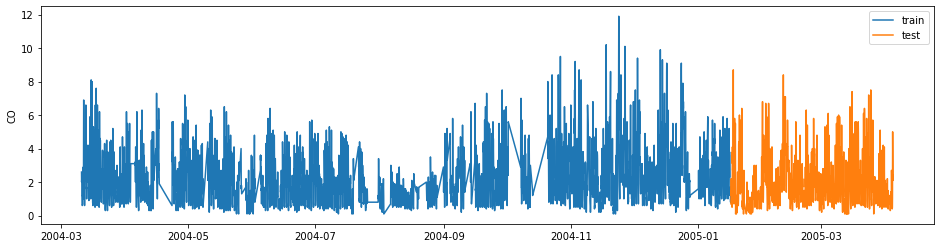

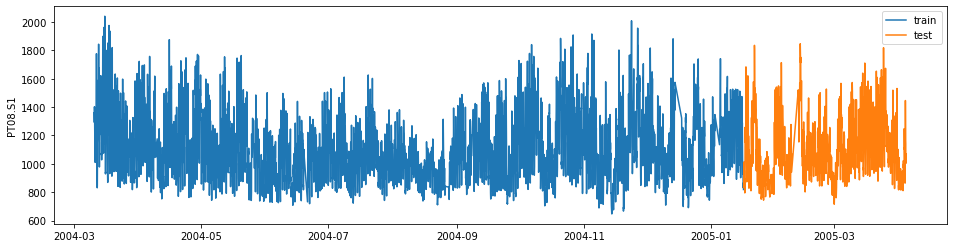

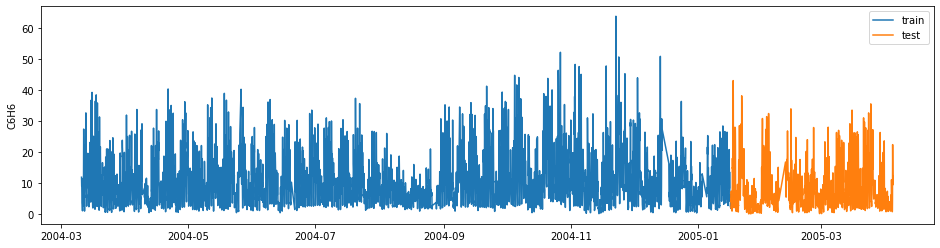

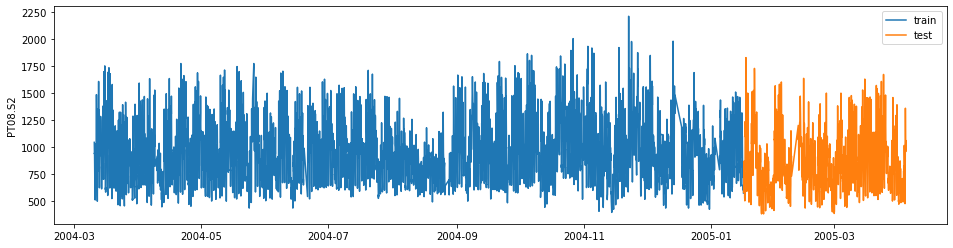

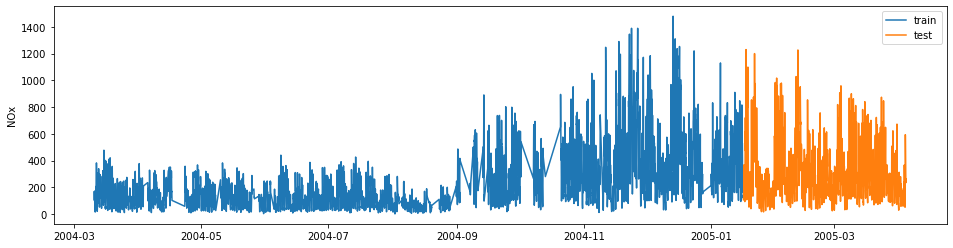

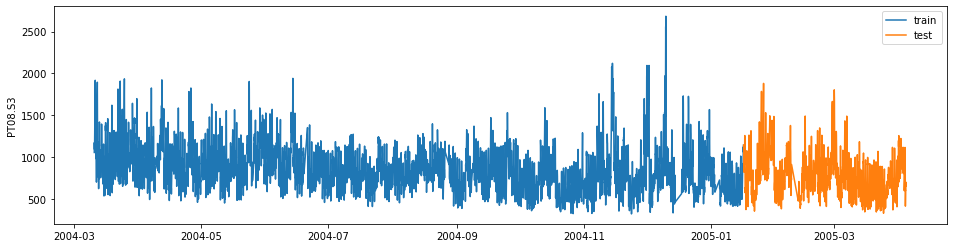

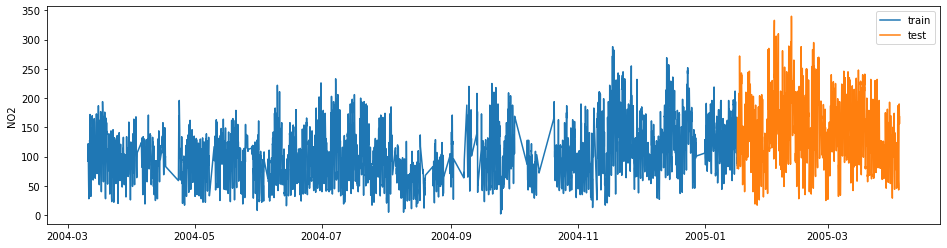

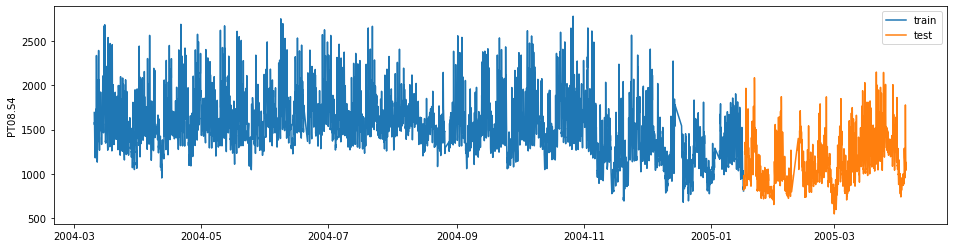

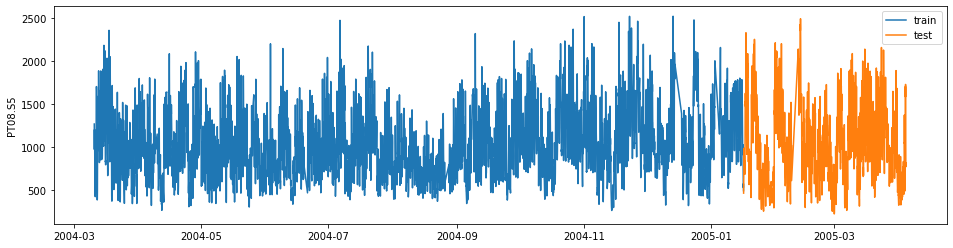

In [8]:
### PLOT ORIGINAL SERIES ###

for col in df.columns:
    plot_sensor(col)

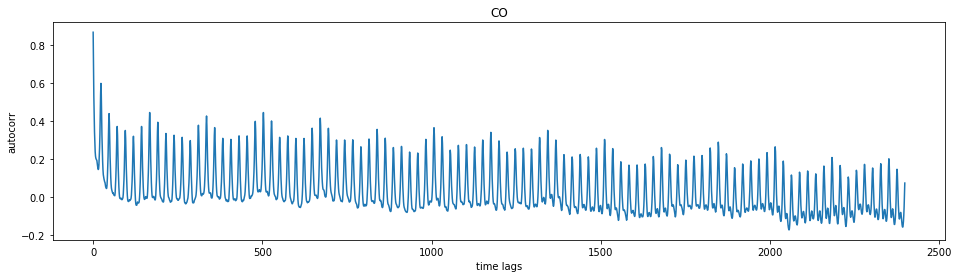

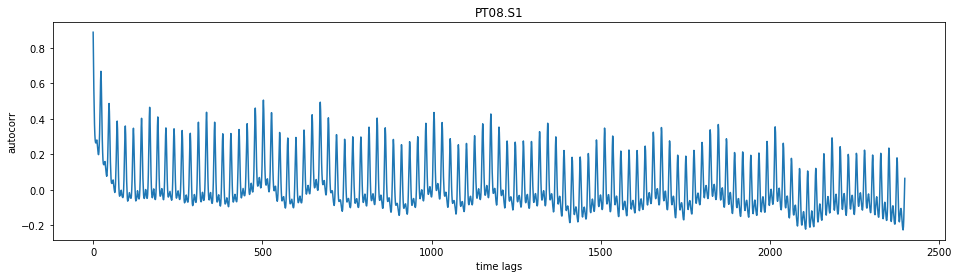

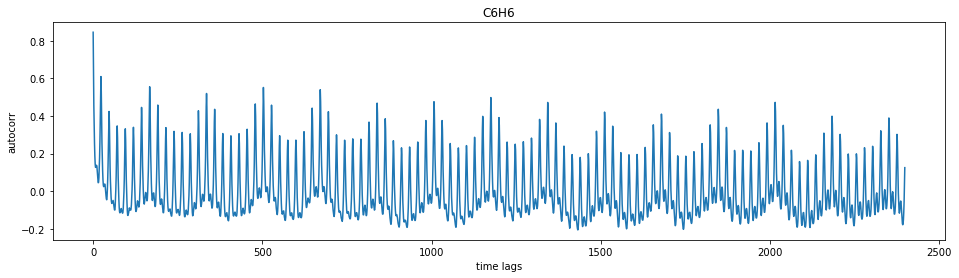

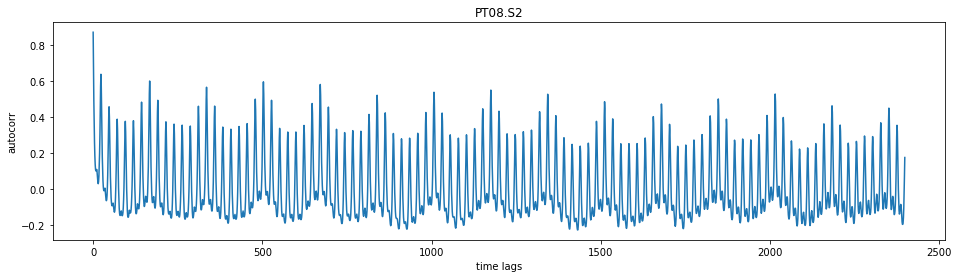

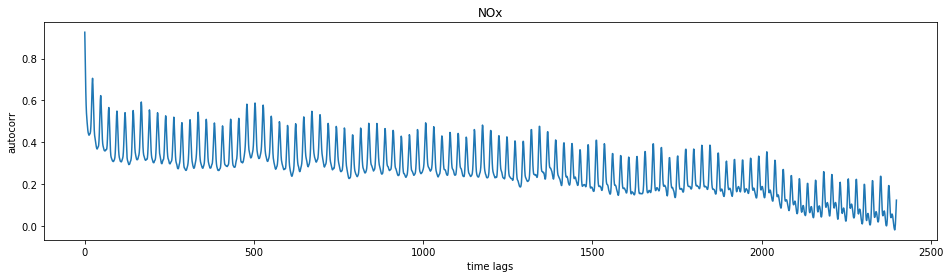

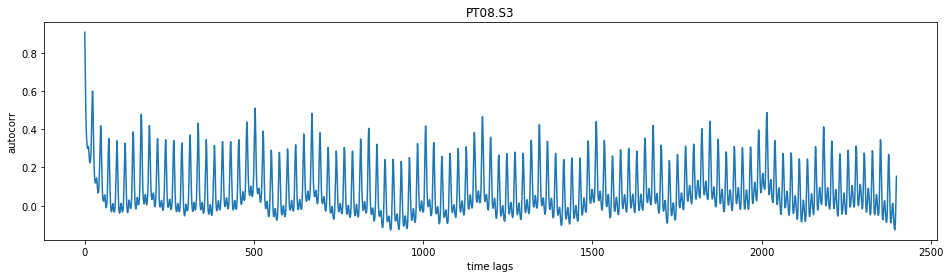

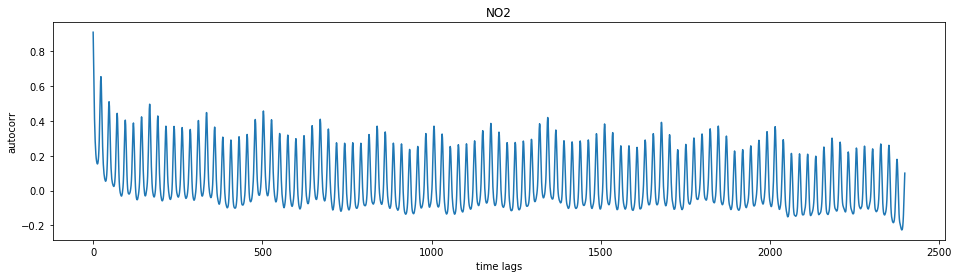

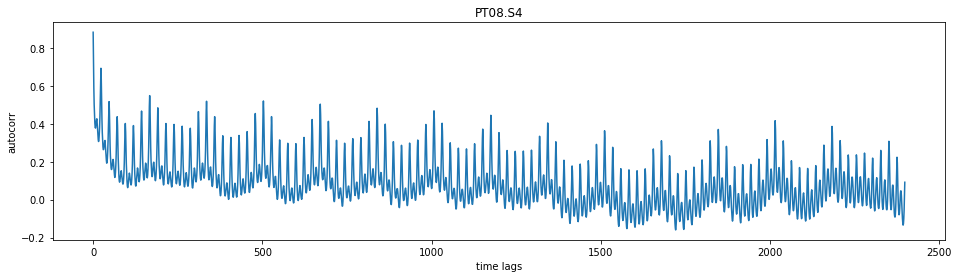

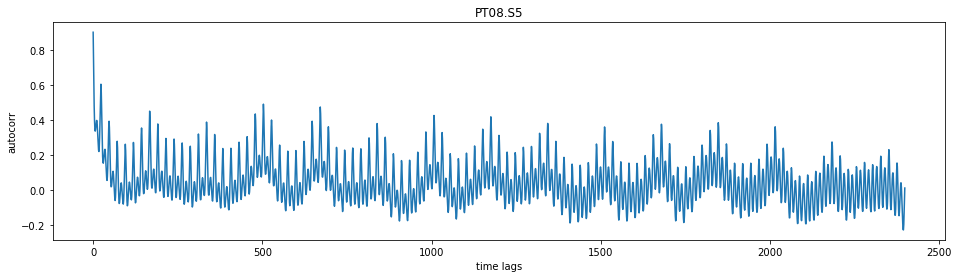

In [9]:
### PLOT AUTOCORRELATION ###

for col in df.columns:
    plot_autocor(col, train)

In [10]:
### OPERATE DIFFERENTIATION ###

period = 24*7

df_diff = df.diff(period).dropna()
df_external = df_external.iloc[period:].copy()

In [11]:
### SPLIT DIFFERENTIAL DATA IN TRAIN AND TEST ###

train_diff = df_diff.iloc[:len(train)-period,:].copy()
test_diff = df_diff.iloc[len(train)-period:,:].copy()

train_init = df.iloc[:len(train)-period,:].copy()
test_init = df.iloc[len(train)-period:-period,:].copy()

train_ext = df_external.iloc[:len(train)-period,:].copy()
test_ext = df_external.iloc[len(train)-period:,:].copy()

print(train_diff.shape, train_init.shape, train_ext.shape)
print(test_diff.shape, test_init.shape, test_ext.shape)

(7317, 9) (7317, 9) (7317, 9)
(1872, 9) (1872, 9) (1872, 9)


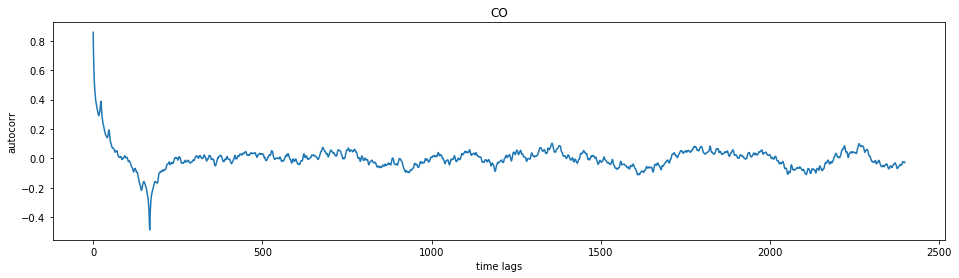

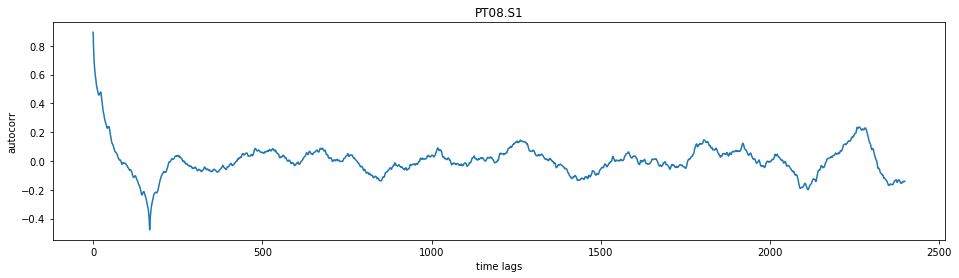

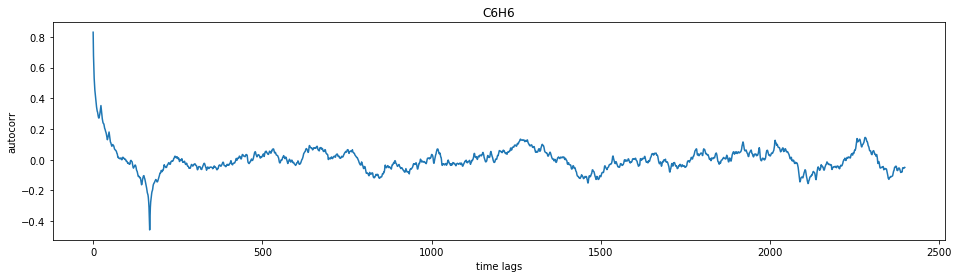

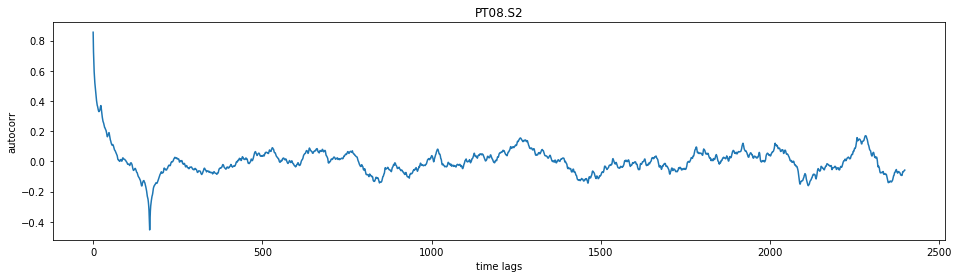

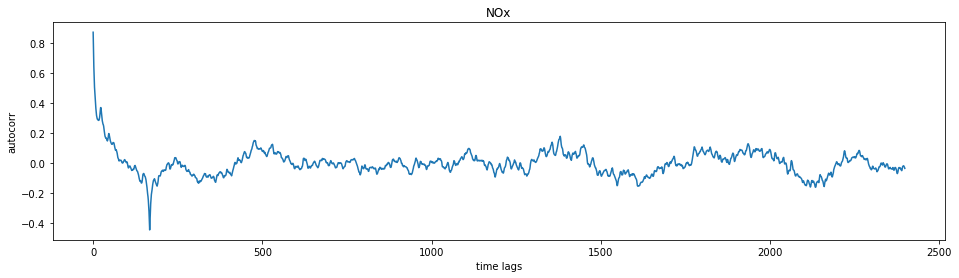

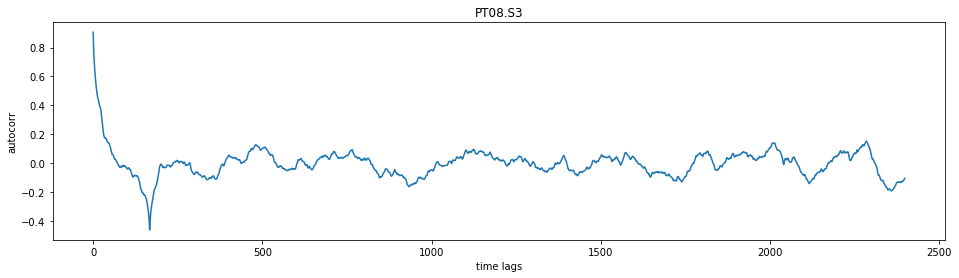

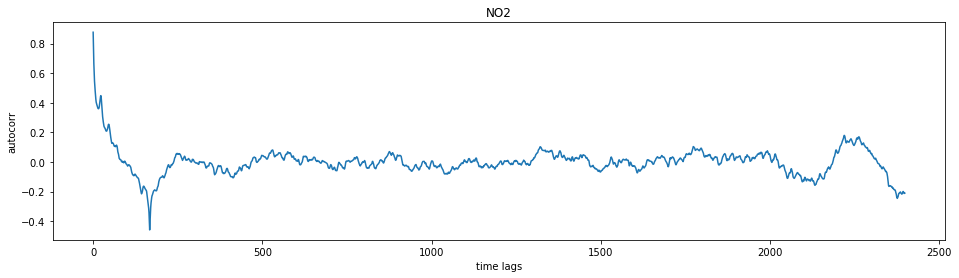

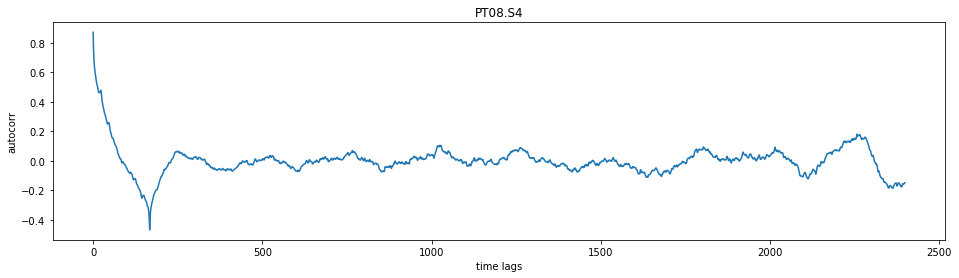

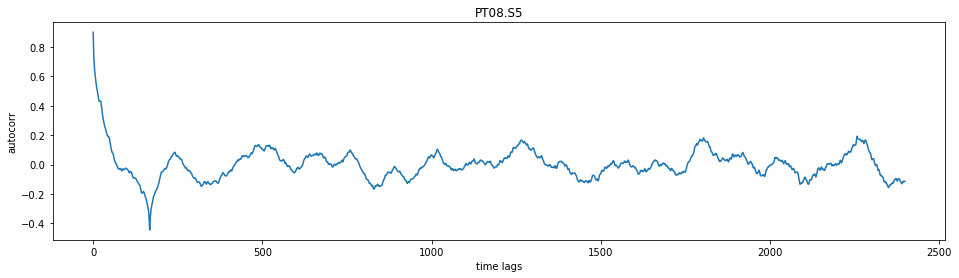

In [12]:
### PLOT DIFFERENTIAL SERIES ###

for col in df.columns:
    plot_autocor(col, train_diff)

In [13]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,50):
    model = VAR(endog=train_diff.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 28 BEST AIC: 53.235108369896906


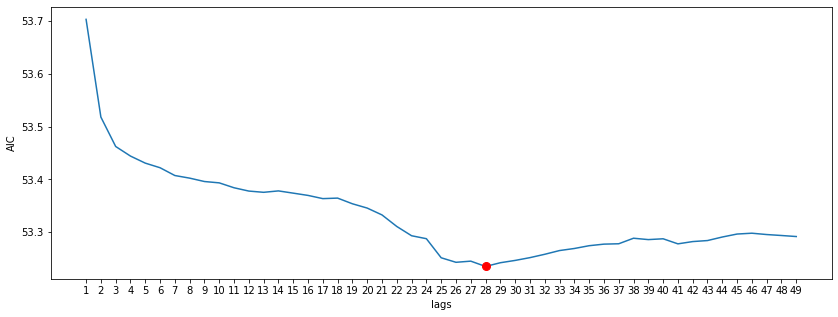

In [14]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,50))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [15]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train_diff.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

53.235108369896906

# VAR LONG-TERM PREDICTION

In [16]:
### UTILITY FUNCTION FOR RETRIVE VAR PREDICTIONS ###

def retrive_prediction(prior, prior_init, steps):
    
    pred = var_result.forecast(np.asarray(prior), steps=steps)
    init = prior_init.tail(period).values
    
    if steps > period:
        id_period = list(range(period))*(steps//period)
        id_period = id_period + list(range(steps-len(id_period)))
    else:
        id_period = list(range(steps))
    
    final_pred = np.zeros((steps, prior.shape[1]))
    for j, (i,p) in enumerate(zip(id_period, pred)):
        final_pred[j] = init[i]+p
        init[i] = init[i]+p    
        
    return final_pred

In [17]:
### RETRIVE PREDICTION AND OBTAIN THE CORRESPONDING ACTUAL VALUES ###

date = '2005-03-07 14:00:00'
forward = 100
date_range = pd.date_range(date, periods=forward+1, freq='H', closed='right')

final_pred = retrive_prediction(df_diff.loc[:date], df.loc[:date], steps = forward)
final_true = df.loc[date_range]

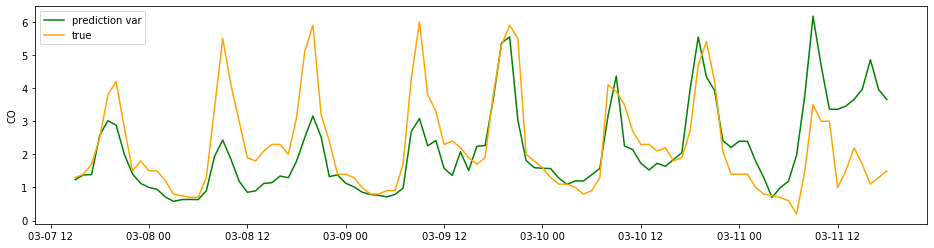

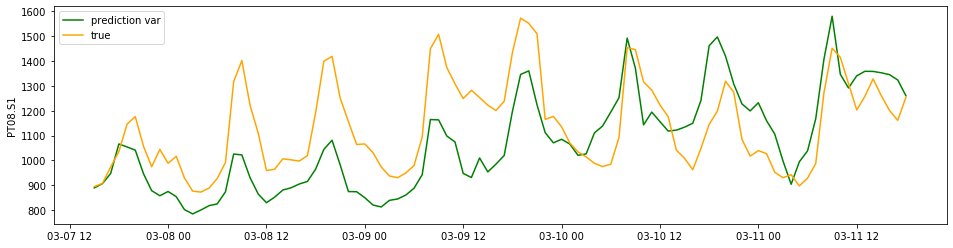

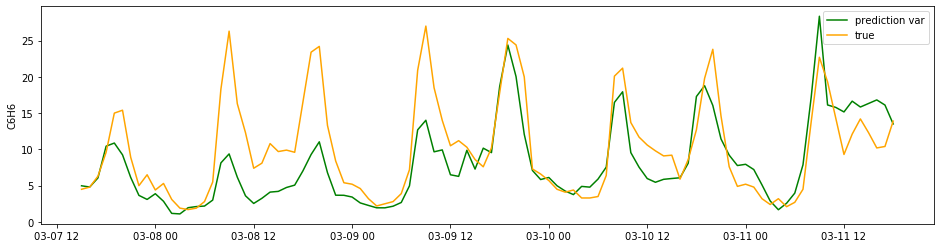

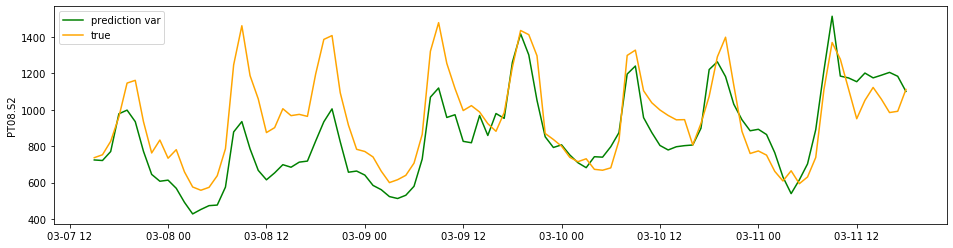

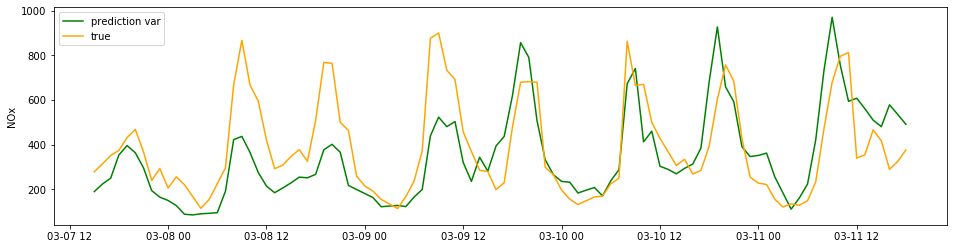

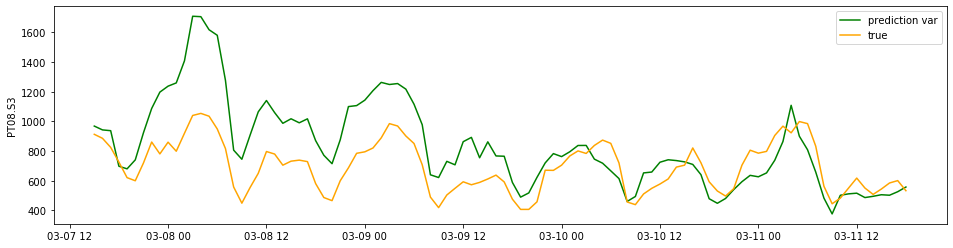

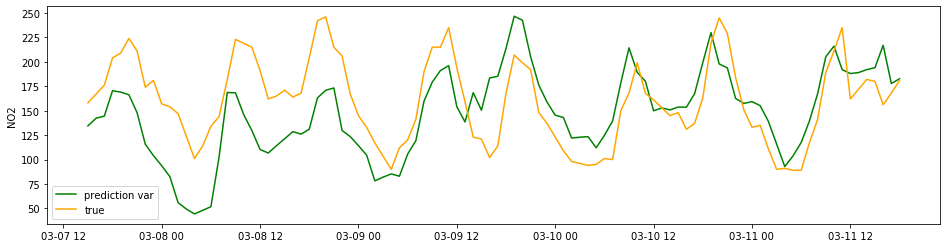

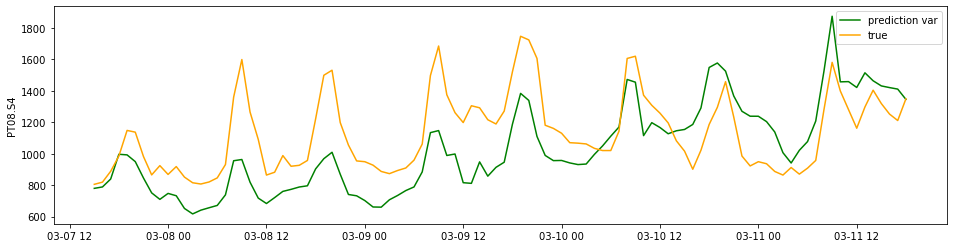

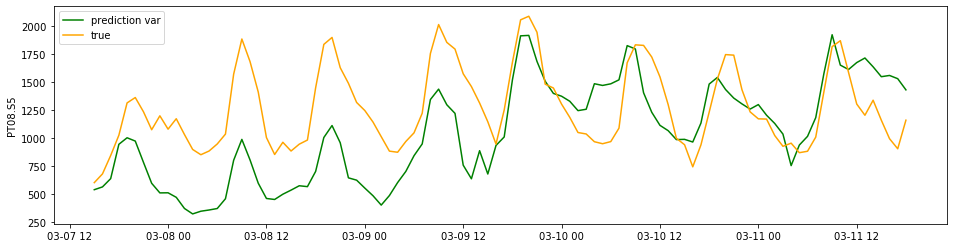

In [18]:
### PLOT ACTUAL vs PREDICTION ###

for i,col in enumerate(df.columns):

    plt.figure(figsize=(16,4))
    plt.plot(date_range, final_pred[:,i], c='green', label='prediction var')
    plt.plot(date_range, final_true[col].values, c='orange', label='true')
    plt.ylabel(col); plt.legend()
    plt.show()

# COMBINE VAR AND LSTM

In [19]:
### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###

def autocor_pred(real, pred, lag=1):
    return pearsonr(real[:-lag], pred[lag:])[0]


seq_length = 30

def get_model():
    
    opt = RMSprop(lr=0.002)
    
    inp = Input(shape=(seq_length, 18))
    
    x = LSTM(64)(inp)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    out = Dense(9)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model

In [20]:
### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

X = var_result.fittedvalues

y_train = train.iloc[period+best_order:].values
y_train_var = X + train_init.iloc[best_order:].values
X_train = np.concatenate([train_diff.iloc[best_order:].values, train_ext.iloc[best_order:].values], axis=1)
X_train_var = np.concatenate([X, train_ext.iloc[best_order:].values], axis=1)

y_val = y_train[int(len(X)*0.8):]
y_val_var = y_train_var[int(len(X)*0.8):]
X_val = X_train[int(len(X)*0.8):]
X_val_var = X_train_var[int(len(X)*0.8):]

y_train = y_train[:int(len(X)*0.8)]
y_train_var = y_train_var[:int(len(X)*0.8)]
X_train = X_train[:int(len(X)*0.8)]
X_train_var = X_train_var[:int(len(X)*0.8)]

y_test = test.values
X_test = np.concatenate([test_diff.values, test_ext.values], axis=1)

In [21]:
### SCALE DATA ###

scaler_y = StandardScaler()
scaler = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_train_var = scaler_y.transform(y_train_var)
y_val = scaler_y.transform(y_val)
y_val_var = scaler_y.transform(y_val_var)
y_test = scaler_y.transform(y_test)

X_train = scaler.fit_transform(X_train)
X_train_var = scaler.transform(X_train_var)
X_val = scaler.transform(X_val)
X_val_var = scaler.transform(X_val_var)
X_test = scaler.transform(X_test)

In [22]:
### BUILD DATA GENERATOR ###

generator_train = TimeseriesGenerator(X_train, y_train, length=seq_length, batch_size=32)
generator_train_var = TimeseriesGenerator(X_train_var, y_train_var, length=seq_length, batch_size=32)
generator_val = TimeseriesGenerator(X_val, y_val, length=seq_length, batch_size=32)
generator_val_var = TimeseriesGenerator(X_val_var, y_val_var, length=seq_length, batch_size=32)
generator_test = TimeseriesGenerator(X_test, y_test, length=seq_length, batch_size=32)

In [23]:
### FIT NEURAL NETWORK WITH VAR FITTED VALUES AND RAW DATA ###

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

print('--------', 'train model with VAR fitted values', '--------')
model_var = get_model()
model_var.fit_generator(generator_train_var, steps_per_epoch= len(generator_train_var),
                        epochs=100, validation_data=generator_val_var, validation_steps = len(generator_val_var), 
                        callbacks=[es], verbose = 1)


print('--------', 'train model with raw data', '--------')
model_var.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                        epochs=100, validation_data=generator_val, validation_steps = len(generator_val), 
                        callbacks=[es], verbose = 1)

-------- train model with VAR fitted values --------
Epoch 1/100
182/182 [==============================] - 12s 68ms/step - loss: 0.8885 - val_loss: 1.3849
Epoch 2/100
182/182 [==============================] - 12s 68ms/step - loss: 0.7060 - val_loss: 1.2668
Epoch 3/100
182/182 [==============================] - 12s 67ms/step - loss: 0.6397 - val_loss: 1.1524
Epoch 4/100
182/182 [==============================] - 12s 67ms/step - loss: 0.5913 - val_loss: 1.1805
Epoch 5/100
182/182 [==============================] - 12s 66ms/step - loss: 0.5546 - val_loss: 1.1741
Epoch 6/100
182/182 [==============================] - 12s 67ms/step - loss: 0.5187 - val_loss: 1.1671
Epoch 7/100
182/182 [==============================] - 12s 67ms/step - loss: 0.5008 - val_loss: 1.1813
Epoch 8/100
182/182 [==============================] - 12s 67ms/step - loss: 0.4906 - val_loss: 1.1340
Epoch 9/100
182/182 [==============================] - 13s 69ms/step - loss: 0.4744 - val_loss: 1.0449
Epoch 10/100
182/182

In [24]:
### OBTAIN PREDICTIONS AND RETRIVE ORIGINAL DATA ###

true = scaler_y.inverse_transform(y_test[seq_length:])

pred = model_var.predict_generator(generator_test)
pred = scaler_y.inverse_transform(pred)

In [25]:
### FIT NEURAL NETWORK WITH ONLY ORIGINAL DATA ###

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

simple_model = get_model()
simple_model.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                            epochs=100, validation_data=generator_val, validation_steps = len(generator_val), 
                            callbacks=[es], verbose = 1)

Epoch 1/100
182/182 [==============================] - 13s 71ms/step - loss: 0.8696 - val_loss: 1.3377
Epoch 2/100
182/182 [==============================] - 13s 72ms/step - loss: 0.6754 - val_loss: 1.2231
Epoch 3/100
182/182 [==============================] - 13s 70ms/step - loss: 0.5990 - val_loss: 1.0698
Epoch 4/100
182/182 [==============================] - 13s 70ms/step - loss: 0.5454 - val_loss: 1.1210
Epoch 5/100
182/182 [==============================] - 14s 75ms/step - loss: 0.5144 - val_loss: 1.1422
Epoch 6/100
182/182 [==============================] - 15s 81ms/step - loss: 0.4840 - val_loss: 1.1434
Epoch 7/100
182/182 [==============================] - 13s 71ms/step - loss: 0.4569 - val_loss: 1.1149
Epoch 8/100
182/182 [==============================] - 13s 71ms/step - loss: 0.4470 - val_loss: 1.1214
Epoch 00008: early stopping


In [26]:
### OBTAIN PREDICTIONS ###

pred_simple = simple_model.predict_generator(generator_test)
pred_simple = scaler_y.inverse_transform(pred_simple)

In [27]:
### COMPUTE METRICS ON TEST DATA ###

diz_error_lstm, diz_ac_lstm = {}, {}
diz_error_var_lstm, diz_ac_var_lstm = {}, {}


for i,col in enumerate(df.columns):
    
    error = mean_absolute_error(true[:,i], pred_simple[:,i])
    diz_error_lstm[col] = error
    
    error = mean_absolute_error(true[:,i], pred[:,i])
    diz_error_var_lstm[col] = error
    
    ac = autocor_pred(true[:,i], pred_simple[:,i])
    diz_ac_lstm[col] = ac
    
    ac = autocor_pred(true[:,i], pred[:,i])
    diz_ac_var_lstm[col] = ac

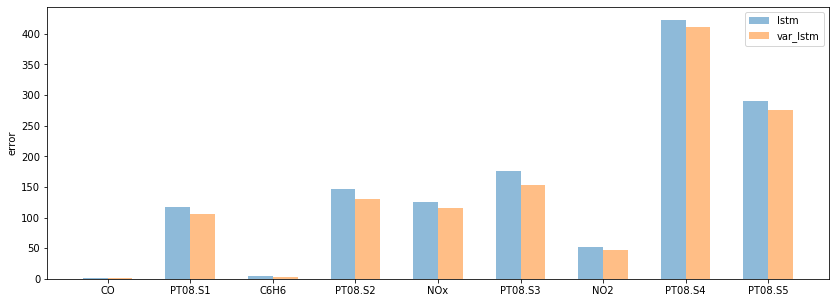

In [28]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_error_lstm))-0.15, diz_error_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_error_var_lstm))+0.15, diz_error_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_error_lstm)), diz_error_lstm.keys())
plt.ylabel('error'); plt.legend()
np.set_printoptions(False)

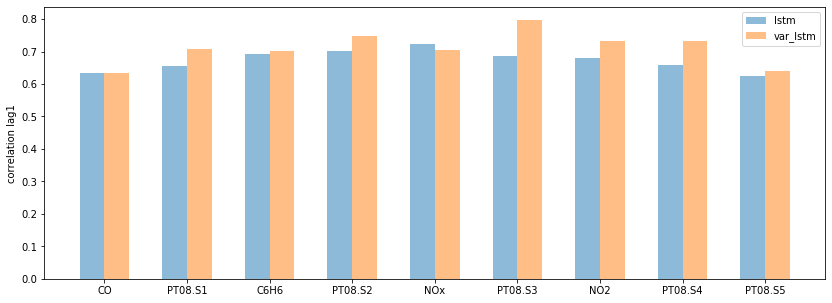

In [29]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_ac_lstm))-0.15, diz_ac_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_ac_var_lstm))+0.15, diz_ac_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_ac_lstm)), diz_ac_lstm.keys())
plt.ylabel('correlation lag1'); plt.legend()
np.set_printoptions(False)